In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [18]:
rho = .88 # density of Argon in natural units
dt  = 0.004 # time step size
T_0 = 1 # temperature

N_cell = 3 # number of unitcells in one direction    
N = 4 * N_cell ** 3 # the total number of particles in the system

L_box = (N / rho) ** (1 / 3) # length of the whole box
L_cell = L_box / N_cell # length of a unitcell

F = np.zeros((N, N, 3)) # matrix that contains all forces
ind = np.triu_indices(N, k=1) # indices of upper triangular matrix
bins = 30

In [48]:
def IC_pos(N_cell, L_cell):
    
    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    
    pos = np.array(pos).reshape((-1, 3))
    
    return pos * L_cell


def IC_vel(N):
    vel = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0) # zero mean vel distirbution
    return vel 


def find_force(pos, L_box=L_box):
    
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box  # PBC
    
    r_sq = np.sum(r_vec**2, axis=1)
    F_vec = -(48 / r_sq ** 7 - 24 / r_sq ** 4)[:, None] * r_vec
    
    F[ind[0], ind[1]] = F_vec
    
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    
    P = np.sum(F_vec * r_vec)
    
    hist,_ = np.histogram(r_sq, bins=bins, range=(0, L_box / 2))
    
    return np.sum(F, axis=0) - np.sum(F, axis=1), pot, P, hist

def time_step(pos, vel, F):
    
    vel += 0.5 * F * dt
    pos = np.mod(pos + vel * dt, L_box)
    F, pot, P, hist = find_force(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)
    return pos, vel, F, pot, kin, P, hist

In [49]:
def simulate():
    
    kins, pots, Ps, hists = [], [], [], []
    
    pos = IC_pos(N_cell, L_cell)
    vel = IC_vel(N)
    F = find_force(pos)[0]
    
    for t in range(10000):
        
        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)
        
        if t > 1000:
            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)
            
        else:
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))   # Scale velocity every 1000 steps
            
    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0)

kins, pots, Ps, hist = simulate()

T = np.mean(kins * 2 / (3 * N))
P = 1 - np.mean(Ps) / (3 * N * T) - 16 * np.pi * rho / (3 * T * L_box**3)

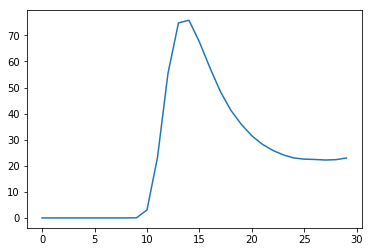

In [50]:
plt.plot(hist)